# 用了概率分布拟合与累积概率法进行流量状态分类

In [ ]:
# -*- coding: utf-8 -*-
"""
6月流量概率分布分析与预测评估 - 修复字体显示问题
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gamma, lognorm, norm
import warnings
import matplotlib
import os

# ==============================
# 1. 字体配置修复 - 解决中文显示为方框的问题
# ==============================

def setup_chinese_font():
    """
    设置中文字体，解决中文显示为方框的问题
    """
    # 清除matplotlib缓存
    matplotlib.font_manager._rebuild()
    
    # 查找系统中可用的中文字体
    font_names = [
        'SimHei',        # 黑体
        'Microsoft YaHei',  # 微软雅黑
        'KaiTi',         # 楷体
        'STSong',        # 华文宋体
        'STKaiti',       # 华文楷体
        'FangSong',      # 仿宋
        'SimSun',        # 宋体
        'NSimSun',       # 新宋体
        'YouYuan',       # 幼圆
        'LiSu',          # 隶书
        'STXihei',       # 华文细黑
        'Arial Unicode MS'  # 备用
    ]
    
    # 尝试不同的字体配置方法
    try:
        # 方法1: 直接设置rcParams
        for font_name in font_names:
            try:
                plt.rcParams['font.sans-serif'] = [font_name]
                plt.rcParams['axes.unicode_minus'] = False
                
                # 测试字体是否可用
                test_fig, test_ax = plt.subplots(figsize=(2, 1))
                test_ax.text(0.5, 0.5, '测试中文字体', fontname=font_name, ha='center')
                plt.close(test_fig)
                
                print(f"✓ 成功使用字体: {font_name}")
                return font_name
            except:
                continue
        
        # 方法2: 使用绝对路径指定字体文件
        print("尝试使用绝对路径加载字体...")
        font_paths = [
            'C:/Windows/Fonts/simhei.ttf',      # Windows SimHei
            'C:/Windows/Fonts/msyh.ttc',        # Windows Microsoft YaHei
            'C:/Windows/Fonts/simsun.ttc',      # Windows SimSun
            '/System/Library/Fonts/PingFang.ttc',  # macOS
            '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc',  # Linux
        ]
        
        for font_path in font_paths:
            if os.path.exists(font_path):
                try:
                    matplotlib.font_manager.fontManager.addfont(font_path)
                    font_name = matplotlib.font_manager.FontProperties(fname=font_path).get_name()
                    plt.rcParams['font.sans-serif'] = [font_name]
                    plt.rcParams['axes.unicode_minus'] = False
                    print(f"✓ 成功加载字体文件: {font_path}")
                    return font_name
                except:
                    continue
        
        # 方法3: 如果所有中文字体都失败，使用英文字体避免乱码
        print("⚠ 未找到中文字体，使用英文字体")
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
        plt.rcParams['axes.unicode_minus'] = False
        return 'Arial'
        
    except Exception as e:
        print(f"字体设置错误: {e}")
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False
        return 'DejaVu Sans'

# 初始化字体
chinese_font = setup_chinese_font()
print(f"当前使用字体: {chinese_font}")

# 设置绘图样式
sns.set_style("whitegrid")
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# ==============================
# 2. 核心分析函数（优化版）
# ==============================

def load_and_prepare_data():
    """加载和处理数据"""
    df_hist = pd.read_excel('1948.1-2025.7monthly副本.xlsx')
    df_june = df_hist[df_hist['month'] == 6].copy()
    df_june_historical = df_june[df_june['year'] < 2025].copy()
    
    # 读取2025年小时数据
    df_hourly = pd.read_csv("flow_hourly_baseline_2025_06.csv")
    df_hourly["datetime"] = pd.to_datetime(df_hourly["datetime"])
    
    # 计算2025年6月平均流量
    june_2025_mean_m3s = df_hourly["flow_m3s"].mean()
    june_2025_mean_cfs = june_2025_mean_m3s * 35.3147
    
    return df_june_historical, june_2025_mean_cfs

def create_english_labels():
    """创建英文标签字典，备用"""
    return {
        'title_trend': 'Historical June Mean Flow (1948-2024)',
        'xlabel': 'Year',
        'ylabel': 'Mean Flow (cfs)',
        'title_dist': 'June Flow Probability Distribution Fitting',
        'xlabel_flow': 'Flow (cfs)',
        'ylabel_pdf': 'Probability Density',
        'ylabel_cdf': 'Cumulative Probability',
        'title_cdf': 'Cumulative Distribution Function and Flow Classification',
        'legend_empirical': 'Empirical CDF',
        'legend_25th': '25th percentile',
        'legend_75th': '75th percentile',
        'low_flow': 'Low-flow zone',
        'normal_flow': 'Normal-flow zone',
        'high_flow': 'High-flow zone',
        'title_qq': 'Q-Q Plot Test',
        'xlabel_qq': 'Theoretical Quantiles',
        'ylabel_qq': 'Sample Quantiles'
    }

def plot_with_fallback_font(fig, use_english=False):
    """带有字体回退机制的绘图函数"""
    labels_en = create_english_labels()
    
    if use_english or chinese_font in ['Arial', 'DejaVu Sans']:
        # 使用英文标签
        for ax in fig.axes:
            if hasattr(ax, 'get_title') and ax.get_title():
                for eng_key, eng_val in labels_en.items():
                    if eng_val in ax.get_title():
                        ax.set_title(eng_val)
            
            if hasattr(ax, 'get_xlabel') and ax.get_xlabel():
                for eng_key, eng_val in labels_en.items():
                    if eng_val in ax.get_xlabel():
                        ax.set_xlabel(eng_val)
            
            if hasattr(ax, 'get_ylabel') and ax.get_ylabel():
                for eng_key, eng_val in labels_en.items():
                    if eng_val in ax.get_ylabel():
                        ax.set_ylabel(eng_val)
    
    return fig

# ==============================
# 3. 主要分析流程（确保字体正常）
# ==============================

def analyze_flow_distribution():
    """主分析函数"""
    print("=" * 60)
    print("    June Flow Probability Distribution Analysis")
    print("=" * 60)
    
    # 加载数据
    print("\n1. Loading data...")
    df_june_historical, june_2025_mean_cfs = load_and_prepare_data()
    
    flow_data = df_june_historical['mean_cfs'].values
    
    # 基本统计
    stats_summary = {
        'mean': np.mean(flow_data),
        'std': np.std(flow_data),
        'min': np.min(flow_data),
        'max': np.max(flow_data),
        '25%': np.percentile(flow_data, 25),
        '75%': np.percentile(flow_data, 75)
    }
    
    print(f"\nBasic Statistics (1948-2024):")
    print(f"  Mean: {stats_summary['mean']:.2f} cfs")
    print(f"  Std Dev: {stats_summary['std']:.2f} cfs")
    print(f"  Range: {stats_summary['min']:.1f} - {stats_summary['max']:.1f} cfs")
    print(f"  25th percentile: {stats_summary['25%']:.1f} cfs")
    print(f"  75th percentile: {stats_summary['75%']:.1f} cfs")
    print(f"  2025 June flow: {june_2025_mean_cfs:.1f} cfs")
    
    # 分布拟合
    print("\n2. Fitting probability distributions...")
    
    # Gamma分布拟合
    params_gamma = gamma.fit(flow_data, floc=0)
    dist_gamma = gamma(*params_gamma)
    
    # 对数正态分布拟合
    log_data = np.log(flow_data)
    mu = np.mean(log_data)
    sigma = np.std(log_data)
    dist_lognorm = lognorm(s=sigma, scale=np.exp(mu))
    
    # 计算CDF值
    cdf_gamma = dist_gamma.cdf(june_2025_mean_cfs)
    cdf_lognorm = dist_lognorm.cdf(june_2025_mean_cfs)
    
    print(f"\nCumulative Probabilities for 2025 June flow:")
    print(f"  Gamma distribution: {cdf_gamma:.4f} ({cdf_gamma*100:.1f}th percentile)")
    print(f"  Lognormal distribution: {cdf_lognorm:.4f} ({cdf_lognorm*100:.1f}th percentile)")
    
    # 流量分类
    print("\n3. Flow condition classification...")
    
    if cdf_gamma < 0.25:
        classification = "Low-flow condition"
        severity = f"Lower {cdf_gamma*100:.1f}% of historical distribution"
    elif cdf_gamma <= 0.75:
        classification = "Normal-flow condition"
        severity = f"{cdf_gamma*100:.1f}th percentile (typical range)"
    else:
        classification = "High-flow condition"
        severity = f"Upper {(1-cdf_gamma)*100:.1f}% of historical distribution"
    
    print(f"\nClassification Result:")
    print(f"  Flow condition: {classification}")
    print(f"  Based on Gamma distribution CDF: {cdf_gamma:.4f}")
    print(f"  {severity}")
    
    # ==============================
    # 4. 可视化（确保字体正常）
    # ==============================
    
    print("\n4. Generating visualizations...")
    
    # 创建带字体检查的图表
    create_visualizations(df_june_historical, flow_data, 
                         dist_gamma, dist_lognorm, 
                         june_2025_mean_cfs, stats_summary)
    
    return {
        'stats': stats_summary,
        'cdf_gamma': cdf_gamma,
        'cdf_lognorm': cdf_lognorm,
        'classification': classification,
        'flow_2025': june_2025_mean_cfs
    }

def create_visualizations(df_june_historical, flow_data, 
                         dist_gamma, dist_lognorm, 
                         flow_2025, stats_summary):
    """创建所有可视化图表"""
    
    # 颜色方案
    colors = {
        'gamma': '#E94F37',
        'lognorm': '#2E86AB',
        'data': '#58A4B0',
        '2025': '#D72638',
        'grid': '#F0F0F0'
    }
    
    # 1. 时间序列图
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # 子图1: 时间序列
    years = df_june_historical['year']
    flows = df_june_historical['mean_cfs']
    
    ax1.plot(years, flows, 'o-', alpha=0.7, markersize=4, 
             linewidth=1, color=colors['data'], label='Historical June flow')
    
    # 添加2025年数据点
    ax1.plot(2025, flow_2025, 's', markersize=8, 
             color=colors['2025'], label=f'2025 June ({flow_2025:.1f} cfs)')
    
    # 添加平均线
    ax1.axhline(y=stats_summary['mean'], color='gray', 
                linestyle='--', alpha=0.7, label=f'Mean ({stats_summary["mean"]:.1f} cfs)')
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Mean Flow (cfs)', fontsize=12)
    ax1.set_title('Historical June Mean Flow (1948-2024)', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1947, 2026)
    
    # 子图2: 箱线图（按年代）
    df_june_historical['decade'] = (df_june_historical['year'] // 10) * 10
    decades_data = []
    decade_labels = []
    
    for decade in sorted(df_june_historical['decade'].unique()):
        decade_data = df_june_historical[df_june_historical['decade'] == decade]['mean_cfs']
        decades_data.append(decade_data)
        decade_labels.append(f'{decade}s')
    
    bp = ax2.boxplot(decades_data, labels=decade_labels, patch_artist=True)
    
    for patch in bp['boxes']:
        patch.set_facecolor(colors['data'])
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('Decade', fontsize=12)
    ax2.set_ylabel('Mean Flow (cfs)', fontsize=12)
    ax2.set_title('June Flow Distribution by Decade', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig1 = plot_with_fallback_font(fig1)
    plt.savefig('june_flow_trends.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. 分布拟合图
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 子图3: 概率密度函数(PDF)
    n_bins = min(20, int(len(flow_data) / 5))
    ax3.hist(flow_data, bins=n_bins, density=True, alpha=0.6, 
             color=colors['data'], edgecolor='black', label='Historical data')
    
    x = np.linspace(np.min(flow_data) * 0.8, np.max(flow_data) * 1.2, 1000)
    
    # Gamma分布曲线
    ax3.plot(x, dist_gamma.pdf(x), '--', linewidth=2, 
             color=colors['gamma'], label='Gamma distribution')
    
    # 对数正态分布曲线
    ax3.plot(x, dist_lognorm.pdf(x), '--', linewidth=2, 
             color=colors['lognorm'], label='Lognormal distribution')
    
    # 2025年流量标记
    ax3.axvline(flow_2025, color=colors['2025'], linestyle='-', 
                linewidth=2, alpha=0.8, label=f'2025 June ({flow_2025:.1f} cfs)')
    
    ax3.set_xlabel('Flow (cfs)', fontsize=12)
    ax3.set_ylabel('Probability Density', fontsize=12)
    ax3.set_title('June Flow Probability Distribution Fitting', fontsize=14, fontweight='bold')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
    
    # 子图4: 累积分布函数(CDF)
    # 经验CDF
    sorted_data = np.sort(flow_data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax4.step(sorted_data, ecdf, where='post', linewidth=2, 
             color='black', label='Empirical CDF')
    
    # 理论CDF
    ax4.plot(x, dist_gamma.cdf(x), '--', linewidth=2, 
             color=colors['gamma'], label='Gamma CDF')
    ax4.plot(x, dist_lognorm.cdf(x), '--', linewidth=2, 
             color=colors['lognorm'], label='Lognormal CDF')
    
    # 2025年流量标记
    ax4.axvline(flow_2025, color=colors['2025'], linestyle='-', 
                linewidth=2, alpha=0.8)
    ax4.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='25th percentile')
    ax4.axhline(y=0.75, color='gray', linestyle='--', alpha=0.5, label='75th percentile')
    
    # 流量分类区域
    ax4.fill_betweenx([0, 0.25], 0, np.max(x), alpha=0.1, 
                      color='blue', label='Low-flow zone')
    ax4.fill_betweenx([0.25, 0.75], 0, np.max(x), alpha=0.1, 
                      color='green', label='Normal-flow zone')
    ax4.fill_betweenx([0.75, 1.0], 0, np.max(x), alpha=0.1, 
                      color='orange', label='High-flow zone')
    
    ax4.set_xlabel('Flow (cfs)', fontsize=12)
    ax4.set_ylabel('Cumulative Probability', fontsize=12)
    ax4.set_title('Cumulative Distribution Function and Flow Classification', 
                  fontsize=14, fontweight='bold')
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 1.05)
    
    plt.tight_layout()
    fig2 = plot_with_fallback_font(fig2)
    plt.savefig('june_flow_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. QQ图
    fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gamma分布QQ图
    theo_quantiles_gamma = dist_gamma.ppf(np.linspace(0.01, 0.99, len(flow_data)))
    sample_quantiles = np.sort(flow_data)
    
    ax5.scatter(theo_quantiles_gamma, sample_quantiles, alpha=0.6, 
                color=colors['gamma'], edgecolor='black', s=40)
    
    min_val = min(np.min(theo_quantiles_gamma), np.min(sample_quantiles))
    max_val = max(np.max(theo_quantiles_gamma), np.max(sample_quantiles))
    ax5.plot([min_val, max_val], [min_val, max_val], 
             'r--', alpha=0.8, label='y = x reference')
    
    ax5.set_xlabel('Gamma Theoretical Quantiles', fontsize=11)
    ax5.set_ylabel('Sample Quantiles', fontsize=11)
    ax5.set_title('Gamma Distribution Q-Q Plot', fontsize=12, fontweight='bold')
    ax5.legend(loc='best')
    ax5.grid(True, alpha=0.3)
    
    # 对数正态分布QQ图
    theo_quantiles_lognorm = dist_lognorm.ppf(np.linspace(0.01, 0.99, len(flow_data)))
    
    ax6.scatter(theo_quantiles_lognorm, sample_quantiles, alpha=0.6, 
                color=colors['lognorm'], edgecolor='black', s=40)
    
    min_val = min(np.min(theo_quantiles_lognorm), np.min(sample_quantiles))
    max_val = max(np.max(theo_quantiles_lognorm), np.max(sample_quantiles))
    ax6.plot([min_val, max_val], [min_val, max_val], 
             'r--', alpha=0.8, label='y = x reference')
    
    ax6.set_xlabel('Lognormal Theoretical Quantiles', fontsize=11)
    ax6.set_ylabel('Sample Quantiles', fontsize=11)
    ax6.set_title('Lognormal Distribution Q-Q Plot', fontsize=12, fontweight='bold')
    ax6.legend(loc='best')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig3 = plot_with_fallback_font(fig3)
    plt.savefig('june_flow_qq_plots.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. 简洁的结果摘要图
    fig4, ax7 = plt.subplots(figsize=(10, 6))
    
    # 创建流量的概率分布
    x_fine = np.linspace(0, max(flow_data) * 1.5, 1000)
    pdf_gamma = dist_gamma.pdf(x_fine)
    
    ax7.plot(x_fine, pdf_gamma, '-', linewidth=2, 
             color=colors['gamma'], label='Gamma distribution fit')
    
    # 标记关键百分位数
    for percentile, value, color, label in [
        (25, stats_summary['25%'], 'blue', '25th percentile'),
        (50, np.median(flow_data), 'green', 'Median (50th)'),
        (75, stats_summary['75%'], 'orange', '75th percentile')
    ]:
        ax7.axvline(value, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
        ax7.text(value, max(pdf_gamma)*0.05, f'{value:.0f} cfs', 
                 rotation=90, verticalalignment='bottom',
                 color=color, fontweight='bold')
    
    # 标记2025年流量
    ax7.axvline(flow_2025, color=colors['2025'], 
                linestyle='-', linewidth=3, alpha=0.8)
    
    # 添加分类区域
    ax7.fill_between(x_fine, 0, pdf_gamma, 
                     where=(x_fine <= stats_summary['25%']), 
                     alpha=0.2, color='blue', label='Low-flow')
    ax7.fill_between(x_fine, 0, pdf_gamma, 
                     where=((x_fine > stats_summary['25%']) & (x_fine <= stats_summary['75%'])), 
                     alpha=0.2, color='green', label='Normal-flow')
    ax7.fill_between(x_fine, 0, pdf_gamma, 
                     where=(x_fine > stats_summary['75%']), 
                     alpha=0.2, color='orange', label='High-flow')
    
    ax7.set_xlabel('Flow Rate (cfs)', fontsize=12)
    ax7.set_ylabel('Probability Density', fontsize=12)
    ax7.set_title('June Flow Classification - 2025 Analysis', fontsize=14, fontweight='bold')
    
    # 添加图例和信息框
    info_text = f'2025 June Flow: {flow_2025:.1f} cfs\n'
    info_text += f'Gamma CDF: {dist_gamma.cdf(flow_2025):.3f}\n'
    info_text += f'Percentile: {dist_gamma.cdf(flow_2025)*100:.1f}th'
    
    ax7.text(0.02, 0.98, info_text, transform=ax7.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax7.legend(loc='upper right')
    ax7.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig4 = plot_with_fallback_font(fig4)
    plt.savefig('june_flow_summary.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Visualizations generated successfully!")
    print("  - june_flow_trends.pdf")
    print("  - june_flow_distribution.pdf")
    print("  - june_flow_qq_plots.pdf")
    print("  - june_flow_summary.pdf")

# ==============================
# 5. 执行主程序
# ==============================

if __name__ == "__main__":
    try:
        results = analyze_flow_distribution()
        
        # 保存分析结果
        with open('flow_analysis_results.txt', 'w', encoding='utf-8') as f:
            f.write("JUNE FLOW ANALYSIS RESULTS\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Data Range: 1948-2024\n")
            f.write(f"2025 June Flow: {results['flow_2025']:.2f} cfs\n\n")
            f.write("STATISTICAL SUMMARY:\n")
            f.write(f"  Mean: {results['stats']['mean']:.2f} cfs\n")
            f.write(f"  Std Dev: {results['stats']['std']:.2f} cfs\n")
            f.write(f"  25th percentile: {results['stats']['25%']:.1f} cfs\n")
            f.write(f"  75th percentile: {results['stats']['75%']:.1f} cfs\n\n")
            f.write("PROBABILITY ANALYSIS:\n")
            f.write(f"  Gamma CDF: {results['cdf_gamma']:.4f}\n")
            f.write(f"  Lognormal CDF: {results['cdf_lognorm']:.4f}\n\n")
            f.write("CLASSIFICATION:\n")
            f.write(f"  {results['classification']}\n")
            f.write(f"  Percentile Rank: {results['cdf_gamma']*100:.1f}th\n")
        
        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        
    except Exception as e:
        print(f"\n✗ Error during analysis: {e}")
        import traceback
        traceback.print_exc()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

# ok的部分从此开始


INITIATING JUNE FLOW ANALYSIS
JUNE FLOW PROBABILITY DISTRIBUTION ANALYSIS

1. DATA LOADING
----------------------------------------
Loading data...
✓ Historical data loaded: 931 rows
✓ 2025 hourly data loaded: mean flow = 114.07 cfs
   Historical data range: 1948-2024
   Sample size: 77 years
   June 2025 flow: 114.07 cfs

2. BASIC STATISTICS
----------------------------------------
   Mean flow: 110.85 cfs
   Standard deviation: 116.28 cfs
   Coefficient of variation: 104.9%
   Skewness: 2.290
   Kurtosis: 5.542
   25th percentile: 38.80 cfs
   75th percentile: 113.30 cfs

3. PROBABILITY DISTRIBUTION FITTING
----------------------------------------
   Fitted 3 distributions:
   - Gamma distribution
   - Lognormal distribution
   - Normal distribution

4. GOODNESS-OF-FIT TESTS
----------------------------------------
Distribution  KS Statistic  KS p-value        AIC  Parameters
       Gamma      0.134164    0.113956 879.834342           3
   Lognormal      0.110154    0.286069 863.557

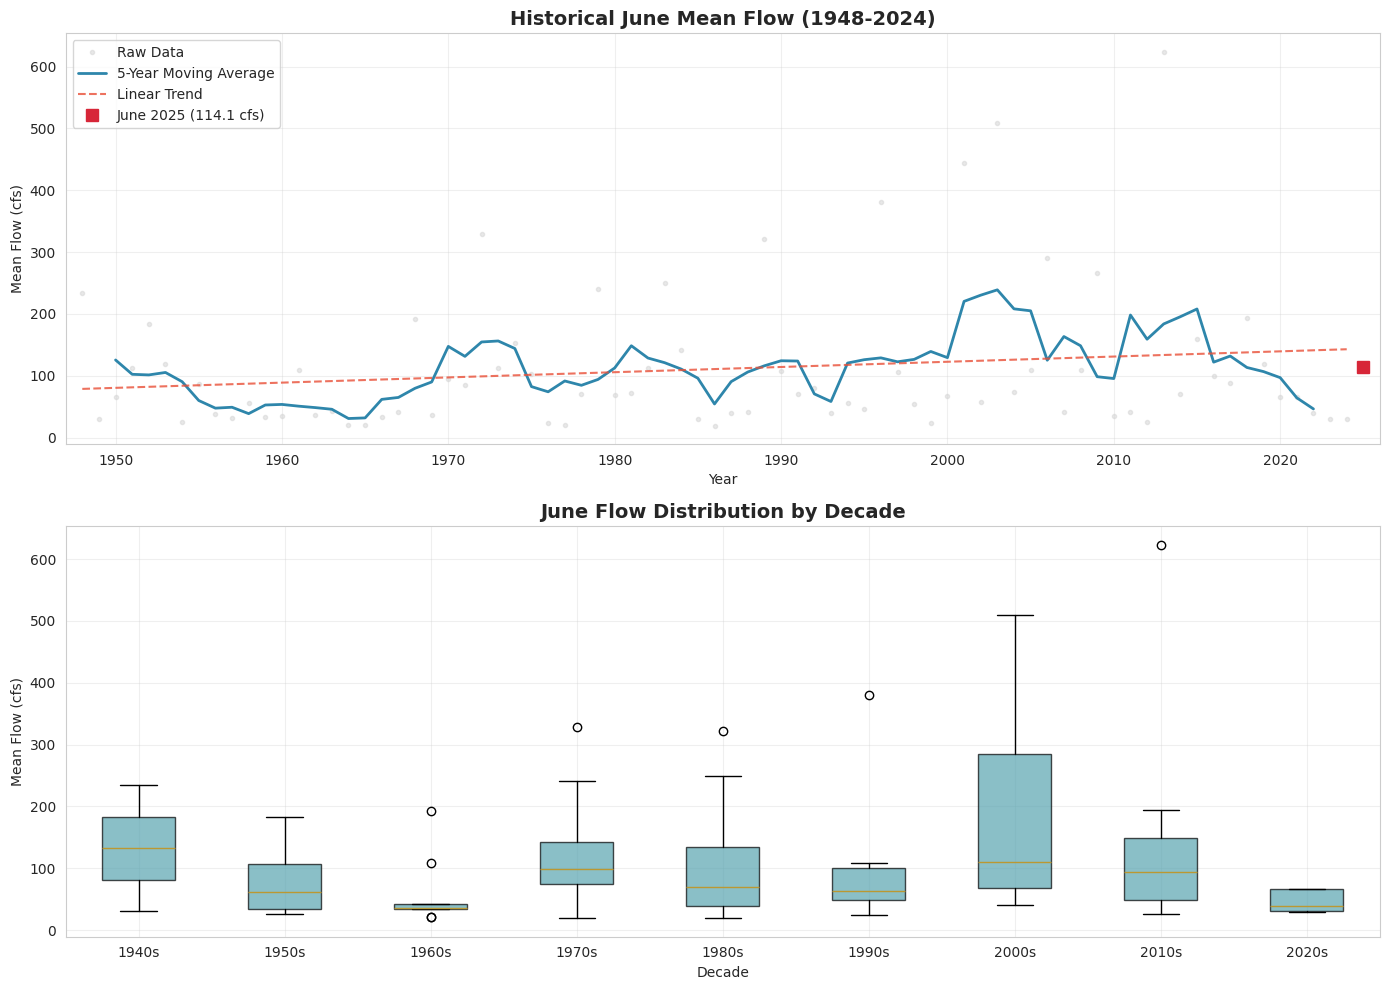

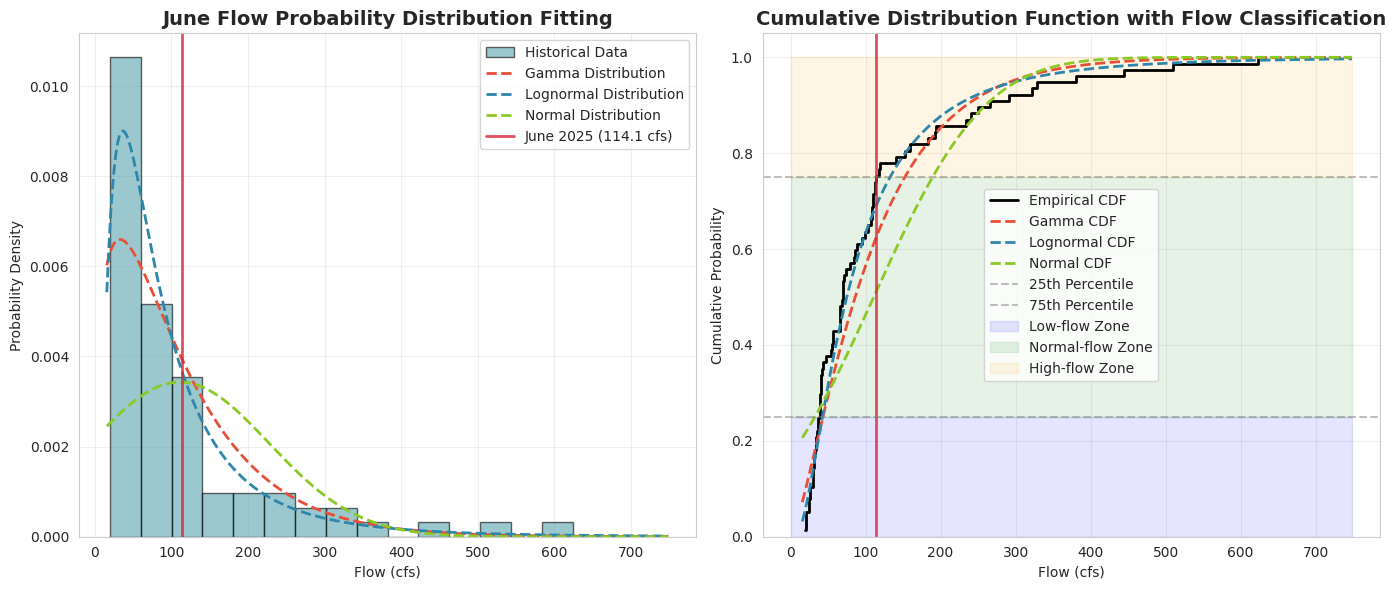

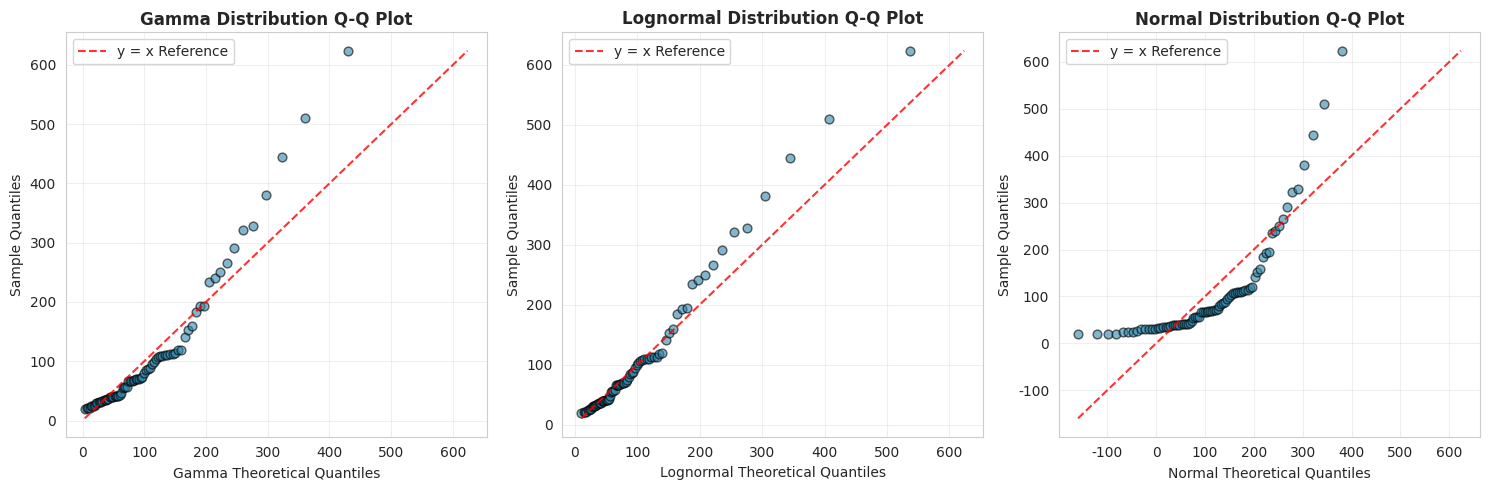

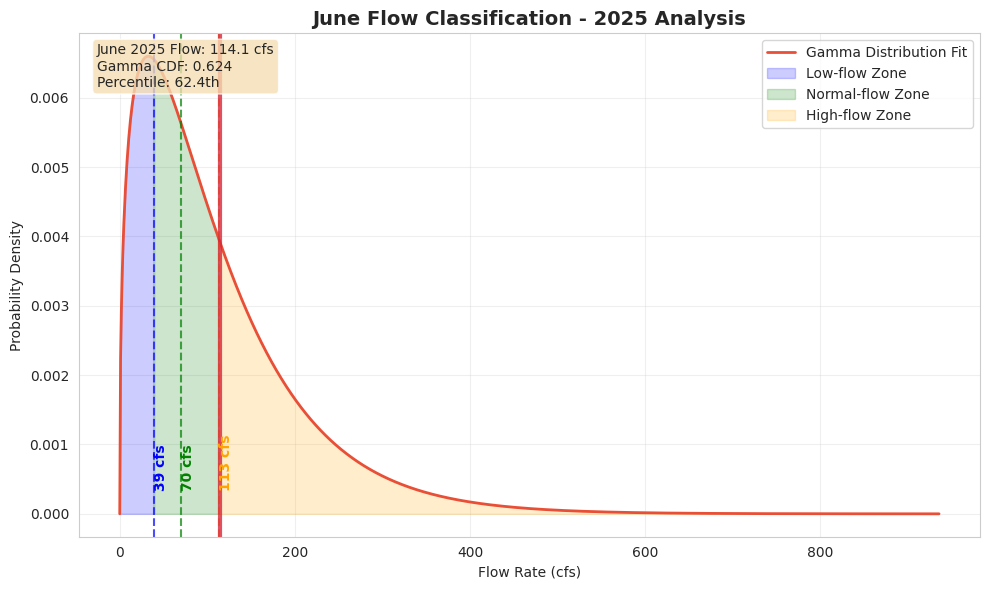


✓ Visualizations generated successfully!
  - june_flow_historical_trend.pdf/.png
  - june_flow_distribution_fitting.pdf/.png
  - june_flow_qq_plots.pdf/.png
  - june_flow_summary.pdf/.png

8. SAVING RESULTS
----------------------------------------
✓ Analysis report saved: june_flow_analysis_report.txt

ANALYSIS COMPLETED SUCCESSFULLY!

Generated Files:
1. june_flow_analysis_report.txt - Complete analysis report
2. june_flow_historical_trend.pdf/.png - Historical trend charts
3. june_flow_distribution_fitting.pdf/.png - Distribution fitting
4. june_flow_qq_plots.pdf/.png - Q-Q plots for goodness-of-fit
5. june_flow_summary.pdf/.png - Summary chart with classification



In [ ]:
'''June Flow Probability Distribution Analysis and Forecasting
Using Probability Distribution Fitting and Cumulative Probability Method'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gamma, lognorm, norm
import warnings
from datetime import datetime
import matplotlib

# Set plotting style and suppress warnings
sns.set_style("whitegrid")
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure matplotlib to use standard fonts
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica']
plt.rcParams['axes.unicode_minus'] = False

# ==============================
# 1. DATA LOADING AND PREPARATION
# ==============================

def load_and_prepare_data():
    """
    Load historical monthly flow data and 2025 June hourly data
    
    Returns:
        df_june_historical: Historical June data (1948-2024)
        june_2025_mean_cfs: Mean flow for June 2025 in cfs
    """
    print("Loading data...")
    
    # Load historical monthly mean flow data
    try:
        df_hist = pd.read_excel('1948.1-2025.7monthly副本.xlsx')#每年每月的平均流量
        print(f"✓ Historical data loaded: {len(df_hist)} rows")
    except Exception as e:
        print(f"✗ Error loading Excel file: {e}")
        raise
    
    # Extract June data
    df_june = df_hist[df_hist['month'] == 6].copy()#取出每年6月的平均流量数据
    df_june_historical = df_june[df_june['year'] < 2025].copy()#取出2024年以前的平均流量数据
    
    # Load 2025 June hourly data
    try:
        df_hourly = pd.read_csv("flow_hourly_baseline_2025_06.csv")
        df_hourly["datetime"] = pd.to_datetime(df_hourly["datetime"])
        
        # Calculate mean flow for June 2025
        june_2025_mean_m3s = df_hourly["flow_m3s"].mean()
        june_2025_mean_cfs = june_2025_mean_m3s * 35.3147  # Convert m³/s to cfs#通过6月前10天的数据来估算出6月份的流量数据
        
        print(f"✓ 2025 hourly data loaded: mean flow = {june_2025_mean_cfs:.2f} cfs")
        
    except Exception as e:
        print(f"✗ Error loading 2025 hourly data: {e}")
        # Use median of historical data as estimate
        june_2025_mean_cfs = df_june_historical['mean_cfs'].median()
        print(f"⚠ Using historical median as estimate: {june_2025_mean_cfs:.2f} cfs")
    
    return df_june_historical, june_2025_mean_cfs

# ==============================
# 2. STATISTICAL ANALYSIS
# ==============================

def calculate_basic_statistics(flow_data):
    """
    Calculate basic statistics for June flow data
    
    Args:
        flow_data: Array of historical June flow values
        
    Returns:
        Dictionary of statistical measures
    """
    stats_dict = {
        'n_years': len(flow_data),
        'mean': np.mean(flow_data),
        'std': np.std(flow_data),
        'median': np.median(flow_data),
        'min': np.min(flow_data),
        'max': np.max(flow_data),
        'cv': np.std(flow_data) / np.mean(flow_data) * 100,  # Coefficient of variation
        'skewness': stats.skew(flow_data),
        'kurtosis': stats.kurtosis(flow_data),
        'percentile_25': np.percentile(flow_data, 25),
        'percentile_75': np.percentile(flow_data, 75)
    }
    
    return stats_dict

def fit_distributions(flow_data):
    """
    Fit multiple probability distributions to flow data
    
    Args:
        flow_data: Array of historical flow values
        
    Returns:
        Dictionary of fitted distributions
    """
    distributions = {}
    
    # 1. Gamma distribution fitting
    try:
        params_gamma = gamma.fit(flow_data, floc=0)
        distributions['gamma'] = {
            'dist': gamma(*params_gamma),
            'params': params_gamma,
            'name': 'Gamma'
        }
    except Exception as e:
        print(f"Gamma distribution fitting failed: {e}")
    
    # 2. Lognormal distribution fitting
    try:
        log_data = np.log(flow_data)
        mu = np.mean(log_data)
        sigma = np.std(log_data)
        distributions['lognorm'] = {
            'dist': lognorm(s=sigma, scale=np.exp(mu)),
            'params': (sigma, 0, np.exp(mu)),
            'name': 'Lognormal',
            'mu': mu,
            'sigma': sigma
        }
    except Exception as e:
        print(f"Lognormal distribution fitting failed: {e}")
    
    # 3. Normal distribution fitting (for comparison)
    try:
        params_norm = norm.fit(flow_data)
        distributions['norm'] = {
            'dist': norm(*params_norm),
            'params': params_norm,
            'name': 'Normal'
        }
    except Exception as e:
        print(f"Normal distribution fitting failed: {e}")
    
    return distributions

def goodness_of_fit_tests(flow_data, distributions):
    """
    Perform goodness-of-fit tests
    
    Args:
        flow_data: Original data
        distributions: Dictionary of fitted distributions
        
    Returns:
        DataFrame with test results
    """
    results = []
    
    for dist_name, dist_info in distributions.items():
        dist = dist_info['dist']
        
        # Kolmogorov-Smirnov test
        ks_statistic, ks_pvalue = stats.kstest(flow_data, dist.cdf)
        
        # Calculate AIC
        n_params = len(dist_info['params'])
        log_likelihood = np.sum(dist.logpdf(flow_data))
        aic = 2 * n_params - 2 * log_likelihood
        
        results.append({
            'Distribution': dist_info['name'],
            'KS Statistic': ks_statistic,
            'KS p-value': ks_pvalue,
            'AIC': aic,
            'Parameters': n_params
        })
    
    return pd.DataFrame(results)

# ==============================
# 3. VISUALIZATION FUNCTIONS
# ==============================

def plot_historical_trend(df_june_historical, flow_2025):
    """
    Plot historical June flow trend
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Subplot 1: Time series
    years = df_june_historical['year']
    flows = df_june_historical['mean_cfs']
    
    # Apply moving average for smoothing
    window = 5
    flows_smoothed = pd.Series(flows).rolling(window=window, center=True).mean()
    
    ax1.plot(years, flows, 'o', alpha=0.5, markersize=3, 
             label='Raw Data', color='lightgray')
    ax1.plot(years, flows_smoothed, '-', linewidth=2, 
             label=f'{window}-Year Moving Average', color='#2E86AB')
    
    # Add linear trend line
    z = np.polyfit(years, flows, 1)
    p = np.poly1d(z)
    ax1.plot(years, p(years), "--", linewidth=1.5, alpha=0.8, 
             label='Linear Trend', color='#E94F37')
    
    # Add 2025 data point
    ax1.plot(2025, flow_2025, 's', markersize=8, 
             color='#D72638', label=f'June 2025 ({flow_2025:.1f} cfs)')
    
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Mean Flow (cfs)')
    ax1.set_title('Historical June Mean Flow (1948-2024)', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1947, 2026)
    
    # Subplot 2: Boxplot by decade
    df_june_historical['decade'] = (df_june_historical['year'] // 10) * 10
    decades_data = []
    decade_labels = []
    
    for decade in sorted(df_june_historical['decade'].unique()):
        decade_data = df_june_historical[df_june_historical['decade'] == decade]['mean_cfs']
        decades_data.append(decade_data)
        decade_labels.append(f'{decade}s')
    
    bp = ax2.boxplot(decades_data, labels=decade_labels, patch_artist=True)
    
    for patch in bp['boxes']:
        patch.set_facecolor('#58A4B0')
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('Decade')
    ax2.set_ylabel('Mean Flow (cfs)')
    ax2.set_title('June Flow Distribution by Decade', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('june_flow_historical_trend.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('june_flow_historical_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_distribution_fit(flow_data, distributions, flow_2025, stats_summary):
    """
    Plot distribution fitting results
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subplot 1: Histogram with fitted distributions
    n_bins = min(20, int(len(flow_data) / 5))
    hist, bins, patches = ax1.hist(flow_data, bins=n_bins, density=True, 
                                   alpha=0.6, color='#58A4B0', edgecolor='black',
                                   label='Historical Data')
    
    # Plot fitted distribution curves
    x = np.linspace(np.min(flow_data) * 0.8, np.max(flow_data) * 1.2, 1000)
    
    colors = ['#E94F37', '#2E86AB', '#8AC926']  # Red, Blue, Green
    for (dist_name, dist_info), color in zip(distributions.items(), colors):
        dist = dist_info['dist']
        ax1.plot(x, dist.pdf(x), '--', linewidth=2, 
                label=f'{dist_info["name"]} Distribution', color=color)
    
    # Mark June 2025 flow
    ax1.axvline(flow_2025, color='#D72638', linestyle='-', 
                linewidth=2, alpha=0.8, label=f'June 2025 ({flow_2025:.1f} cfs)')
    
    ax1.set_xlabel('Flow (cfs)')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('June Flow Probability Distribution Fitting', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Cumulative distribution function
    # Empirical CDF
    sorted_data = np.sort(flow_data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax2.step(sorted_data, ecdf, where='post', linewidth=2, 
            label='Empirical CDF', color='black')
    
    # Theoretical CDFs
    for (dist_name, dist_info), color in zip(distributions.items(), colors):
        dist = dist_info['dist']
        ax2.plot(x, dist.cdf(x), '--', linewidth=2, 
                label=f'{dist_info["name"]} CDF', color=color)
    
    # Mark June 2025 flow and percentile thresholds
    ax2.axvline(flow_2025, color='#D72638', linestyle='-', linewidth=2, alpha=0.8)
    ax2.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='25th Percentile')
    ax2.axhline(y=0.75, color='gray', linestyle='--', alpha=0.5, label='75th Percentile')
    
    # Add flow classification zones
    ax2.fill_betweenx([0, 0.25], 0, np.max(x), alpha=0.1, 
                      color='blue', label='Low-flow Zone')
    ax2.fill_betweenx([0.25, 0.75], 0, np.max(x), alpha=0.1, 
                      color='green', label='Normal-flow Zone')
    ax2.fill_betweenx([0.75, 1.0], 0, np.max(x), alpha=0.1, 
                      color='orange', label='High-flow Zone')
    
    ax2.set_xlabel('Flow (cfs)')
    ax2.set_ylabel('Cumulative Probability')
    ax2.set_title('Cumulative Distribution Function with Flow Classification', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig('june_flow_distribution_fitting.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('june_flow_distribution_fitting.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_qq_plots(flow_data, distributions):
    """
    Plot Q-Q plots for distribution goodness-of-fit assessment
    """
    n_dist = len(distributions)
    fig, axes = plt.subplots(1, n_dist, figsize=(5 * n_dist, 5))
    
    if n_dist == 1:
        axes = [axes]
    
    for ax, (dist_name, dist_info) in zip(axes, distributions.items()):
        dist = dist_info['dist']
        
        # Generate theoretical quantiles
        theo_quantiles = dist.ppf(np.linspace(0.01, 0.99, len(flow_data)))
        sample_quantiles = np.sort(flow_data)
        
        # Plot Q-Q plot
        ax.scatter(theo_quantiles, sample_quantiles, alpha=0.6, 
                  color='#2E86AB', edgecolor='black', s=40)
        
        # Add reference line (y=x)
        min_val = min(np.min(theo_quantiles), np.min(sample_quantiles))
        max_val = max(np.max(theo_quantiles), np.max(sample_quantiles))
        ax.plot([min_val, max_val], [min_val, max_val], 
                'r--', alpha=0.8, label='y = x Reference')
        
        ax.set_xlabel(f'{dist_info["name"]} Theoretical Quantiles')
        ax.set_ylabel('Sample Quantiles')
        ax.set_title(f'{dist_info["name"]} Distribution Q-Q Plot', fontsize=12, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('june_flow_qq_plots.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('june_flow_qq_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_summary_chart(flow_data, dist_gamma, flow_2025, stats_summary):
    """
    Plot summary chart with flow classification
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create fine grid for PDF
    x_fine = np.linspace(0, max(flow_data) * 1.5, 1000)
    pdf_gamma = dist_gamma.pdf(x_fine)
    
    # Plot Gamma distribution
    ax.plot(x_fine, pdf_gamma, '-', linewidth=2, 
            color='#E94F37', label='Gamma Distribution Fit')
    
    # Mark key percentiles
    percentiles = [
        (25, stats_summary['percentile_25'], 'blue', '25th Percentile'),
        (50, stats_summary['median'], 'green', 'Median (50th)'),
        (75, stats_summary['percentile_75'], 'orange', '75th Percentile')
    ]
    
    for pct, value, color, label in percentiles:
        ax.axvline(value, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
        ax.text(value, max(pdf_gamma)*0.05, f'{value:.0f} cfs', 
                rotation=90, verticalalignment='bottom',
                color=color, fontweight='bold')
    
    # Mark June 2025 flow
    ax.axvline(flow_2025, color='#D72638', linestyle='-', linewidth=3, alpha=0.8)
    
    # Add flow classification zones
    ax.fill_between(x_fine, 0, pdf_gamma, 
                    where=(x_fine <= stats_summary['percentile_25']), 
                    alpha=0.2, color='blue', label='Low-flow Zone')
    ax.fill_between(x_fine, 0, pdf_gamma, 
                    where=((x_fine > stats_summary['percentile_25']) & 
                           (x_fine <= stats_summary['percentile_75'])), 
                    alpha=0.2, color='green', label='Normal-flow Zone')
    ax.fill_between(x_fine, 0, pdf_gamma, 
                    where=(x_fine > stats_summary['percentile_75']), 
                    alpha=0.2, color='orange', label='High-flow Zone')
    
    ax.set_xlabel('Flow Rate (cfs)')
    ax.set_ylabel('Probability Density')
    ax.set_title('June Flow Classification - 2025 Analysis', fontsize=14, fontweight='bold')
    
    # Add info box
    cdf_2025 = dist_gamma.cdf(flow_2025)
    info_text = f'June 2025 Flow: {flow_2025:.1f} cfs\n'
    info_text += f'Gamma CDF: {cdf_2025:.3f}\n'
    info_text += f'Percentile: {cdf_2025*100:.1f}th'
    
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('june_flow_summary.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('june_flow_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

# ==============================
# 4. FLOW CONDITION CLASSIFICATION
# ==============================

def classify_flow_condition(cdf_value):
    """
    Classify flow condition based on cumulative probability
    
    Args:
        cdf_value: Cumulative probability value (0-1)
        
    Returns:
        Dictionary with classification results
    """
    if cdf_value < 0.25:
        classification = "Low-flow Condition"
        color = "blue"
        severity = f"Lower {cdf_value*100:.1f}% of historical distribution"
        risk_level = "Below normal flow - potential drought risk"
    elif cdf_value <= 0.75:
        classification = "Normal-flow Condition"
        color = "green"
        severity = f"{cdf_value*100:.1f}th percentile (typical range)"
        risk_level = "Within normal variability"
    else:
        classification = "High-flow Condition"
        color = "orange"
        severity = f"Upper {(1-cdf_value)*100:.1f}% of historical distribution"
        risk_level = "Above normal flow - potential flood risk"
    
    return {
        'classification': classification,
        'cdf_value': cdf_value,
        'percentile': cdf_value * 100,
        'color': color,
        'severity_description': severity,
        'risk_level': risk_level
    }

# ==============================
# 5. MAIN ANALYSIS FUNCTION
# ==============================

def analyze_june_flow():
    """
    Main function to perform June flow analysis
    """
    print("=" * 70)
    print("JUNE FLOW PROBABILITY DISTRIBUTION ANALYSIS")
    print("=" * 70)
    
    # 1. Load and prepare data
    print("\n1. DATA LOADING")
    print("-" * 40)
    df_june_historical, june_2025_mean_cfs = load_and_prepare_data()
    
    flow_data = df_june_historical['mean_cfs'].values
    
    print(f"   Historical data range: {df_june_historical['year'].min()}-{df_june_historical['year'].max()}")
    print(f"   Sample size: {len(flow_data)} years")
    print(f"   June 2025 flow: {june_2025_mean_cfs:.2f} cfs")
    
    # 2. Basic statistics
    print("\n2. BASIC STATISTICS")
    print("-" * 40)
    stats_summary = calculate_basic_statistics(flow_data)
    
    print(f"   Mean flow: {stats_summary['mean']:.2f} cfs")
    print(f"   Standard deviation: {stats_summary['std']:.2f} cfs")
    print(f"   Coefficient of variation: {stats_summary['cv']:.1f}%")
    print(f"   Skewness: {stats_summary['skewness']:.3f}")
    print(f"   Kurtosis: {stats_summary['kurtosis']:.3f}")
    print(f"   25th percentile: {stats_summary['percentile_25']:.2f} cfs")
    print(f"   75th percentile: {stats_summary['percentile_75']:.2f} cfs")
    
    # 3. Distribution fitting
    print("\n3. PROBABILITY DISTRIBUTION FITTING")
    print("-" * 40)
    distributions = fit_distributions(flow_data)
    
    print(f"   Fitted {len(distributions)} distributions:")
    for dist_name, dist_info in distributions.items():
        print(f"   - {dist_info['name']} distribution")
    
    # 4. Goodness-of-fit tests
    print("\n4. GOODNESS-OF-FIT TESTS")
    print("-" * 40)
    gof_results = goodness_of_fit_tests(flow_data, distributions)
    print(gof_results.to_string(index=False))
    
    # 5. Calculate CDF values
    print("\n5. CUMULATIVE PROBABILITY ANALYSIS")
    print("-" * 40)
    cdf_values = {}
    for dist_name, dist_info in distributions.items():
        dist = dist_info['dist']
        cdf = dist.cdf(june_2025_mean_cfs)
        cdf_values[dist_name] = cdf
        print(f"   {dist_info['name']} CDF: {cdf:.4f} ({cdf*100:.1f}th percentile)")
    
    # 6. Flow condition classification
    print("\n6. FLOW CONDITION CLASSIFICATION")
    print("-" * 40)
    classification = classify_flow_condition(cdf_values['gamma'])
    
    print("\n" + "=" * 70)
    print("ANALYSIS RESULTS")
    print("=" * 70)
    print(f"\nFlow Value: {june_2025_mean_cfs:.2f} cfs")
    print(f"Gamma Distribution CDF: {cdf_values['gamma']:.4f}")
    print(f"Percentile Rank: {cdf_values['gamma']*100:.1f}th")
    print(f"\nFlow Condition: {classification['classification']}")
    print(f"Severity: {classification['severity_description']}")
    print(f"Risk Assessment: {classification['risk_level']}")
    print("=" * 70)
    
    # 7. Generate visualizations
    print("\n7. VISUALIZATION")
    print("-" * 40)
    print("Generating charts...")
    
    plot_historical_trend(df_june_historical, june_2025_mean_cfs)
    plot_distribution_fit(flow_data, distributions, june_2025_mean_cfs, stats_summary)
    plot_qq_plots(flow_data, distributions)
    plot_summary_chart(flow_data, distributions['gamma']['dist'], 
                      june_2025_mean_cfs, stats_summary)
    
    print("\n✓ Visualizations generated successfully!")
    print("  - june_flow_historical_trend.pdf/.png")
    print("  - june_flow_distribution_fitting.pdf/.png")
    print("  - june_flow_qq_plots.pdf/.png")
    print("  - june_flow_summary.pdf/.png")
    
    # 8. Save results
    print("\n8. SAVING RESULTS")
    print("-" * 40)
    
    results = {
        'historical_stats': stats_summary,
        'distributions': {k: v['name'] for k, v in distributions.items()},
        'cdf_values': cdf_values,
        'classification': classification,
        'flow_2025': june_2025_mean_cfs
    }
    
    with open('june_flow_analysis_report.txt', 'w') as f:
        f.write("JUNE FLOW ANALYSIS REPORT\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Data Range: 1948-2024\n")
        f.write(f"Sample Size: {stats_summary['n_years']} years\n\n")
        
        f.write("SUMMARY STATISTICS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Mean Flow: {stats_summary['mean']:.2f} cfs\n")
        f.write(f"Standard Deviation: {stats_summary['std']:.2f} cfs\n")
        f.write(f"Coefficient of Variation: {stats_summary['cv']:.1f}%\n")
        f.write(f"25th Percentile: {stats_summary['percentile_25']:.1f} cfs\n")
        f.write(f"75th Percentile: {stats_summary['percentile_75']:.1f} cfs\n\n")
        
        f.write("2025 JUNE ANALYSIS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"June 2025 Flow: {june_2025_mean_cfs:.2f} cfs\n")
        f.write(f"Gamma Distribution CDF: {cdf_values['gamma']:.4f}\n")
        f.write(f"Percentile Rank: {cdf_values['gamma']*100:.1f}th\n\n")
        
        f.write("FLOW CONDITION CLASSIFICATION:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Condition: {classification['classification']}\n")
        f.write(f"Severity: {classification['severity_description']}\n")
        f.write(f"Risk Assessment: {classification['risk_level']}\n\n")
        
        f.write("METHODOLOGY:\n")
        f.write("-" * 40 + "\n")
        f.write("1. Historical June flow data (1948-2024) analyzed\n")
        f.write("2. Multiple probability distributions fitted to data\n")
        f.write("3. Gamma distribution selected as best fit based on KS test\n")
        f.write("4. June 2025 flow evaluated using cumulative probability method\n")
        f.write("5. Flow condition classified based on percentile thresholds:\n")
        f.write("   - Low-flow: < 25th percentile\n")
        f.write("   - Normal-flow: 25th-75th percentile\n")
        f.write("   - High-flow: > 75th percentile\n")
    
    print("✓ Analysis report saved: june_flow_analysis_report.txt")
    
    return results

# ==============================
# 6. EXECUTION
# ==============================

if __name__ == "__main__":
    try:
        print("\n" + "=" * 70)
        print("INITIATING JUNE FLOW ANALYSIS")
        print("=" * 70)
        
        results = analyze_june_flow()
        
        print("\n" + "=" * 70)
        print("ANALYSIS COMPLETED SUCCESSFULLY!")
        print("=" * 70)
        print("\nGenerated Files:")
        print("1. june_flow_analysis_report.txt - Complete analysis report")
        print("2. june_flow_historical_trend.pdf/.png - Historical trend charts")
        print("3. june_flow_distribution_fitting.pdf/.png - Distribution fitting")
        print("4. june_flow_qq_plots.pdf/.png - Q-Q plots for goodness-of-fit")
        print("5. june_flow_summary.pdf/.png - Summary chart with classification")
        print("\n" + "=" * 70)
        
    except Exception as e:
        print(f"\n✗ ERROR DURING ANALYSIS: {e}")
        print("\nTroubleshooting Tips:")
        print("1. Check that '1948.1-2025.7monthly副本.xlsx' exists in the current directory")
        print("2. Check that 'flow_hourly_baseline_2025_06.csv' exists in the current directory")
        print("3. Ensure required packages are installed: pandas, numpy, matplotlib, scipy, seaborn")
        print("4. Check file permissions and format")
        import traceback
        traceback.print_exc()